In [2]:
from collections.abc import Iterable
import os

from adjustText import adjust_text
import colorsys
from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import latex
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import pywt
import scipy.io as sio
import scipy
from scipy.stats import multivariate_normal, spearmanr
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile
import tifffile

from networkx import kamada_kawai_layout

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
#from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [3]:
#Optional import if you want to open figures in a separate window, add %matplotlib qt to top of any code box if you want figures to open in a separate window 
import PyQt6.QtCore
os.environ["QT_API"] = "pyqt6"

# Figure 5: Benchmarking atlas performances

Figure 5 demonstrates the results of benchmarking three different atlases on the full corpus of data. 

In [3]:
atlas = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_match_full_nosplit.pkl') # Load atlas
atlas_df = atlas.get_df()
atlas_neurons = np.asarray(atlas_df['ID'])
atlas.df = atlas.df.drop(atlas.df[atlas.df['ID']=='IL1V'].index)

In [5]:
'''
Can either load datasets using get_dataset_neurons with path to a folder of NWB files or using get_dataset_online to stream in data from an online dandiset.
Note that streaming from online will take much longer to load here but bypasses the need to have any files stored on your local hard drive.
'''

data_path = 'insert path to folder containing NWB files to load or stream from online'
#dataset = get_dataset_neurons(data_path, atlas_neurons)

EY_dataset = get_dataset_online('000541', atlas_neurons) #dandi_id = 000541
SK1_dataset = get_dataset_online('000565', atlas_neurons) #dandi_id = 000565
NP_dataset = get_dataset_online('000715', atlas_neurons) #dandi_id = 000715
SK2_dataset = get_dataset_online('000472', atlas_neurons) #dandi_id = 000472
HL_dataset = get_dataset_online('000714', atlas_neurons) #dandi_id = 000714
KK_dataset = get_dataset_online('000692', atlas_neurons) #dandi_id = 000692
SF_dataset = get_dataset_online('000776', atlas_neurons) #dandi_id = 000776

A newer version (0.62.1) of dandi/dandi-cli is available. You are using 0.61.2
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190924_01


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190925_01


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190924_02


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190924_03


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190925_04


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190928_01


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190928_05


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190928_07


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190928_08


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190928_03


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190928_11


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190929_02


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


KeyboardInterrupt: 

In [4]:
def maha_dist(data, mu, sigma):

    data_mu = data-mu
    inv_sigma = np.linalg.inv(sigma)
    left_data = np.dot(data_mu, inv_sigma)
    mahal = np.dot(left_data, data_mu.T)

    return np.sqrt(mahal)

def run_linear_assignment(df_data, atlas):
    #df_data should have columns 'X', 'Y', 'Z', 'R', 'G', 'B', 'ID' 

    df_assigns = df_data.copy()

    mu = atlas.mu
    sigma = atlas.sigma
    neurons = np.asarray(atlas.neurons)

    xyzrgb = np.asarray(df_data[['X','Y','Z','R','G','B']])
    gt_labels = np.asarray(df_data['ID'])

    assigns = np.empty((xyzrgb.shape[0],5),np.dtype('U100'))
    assign_cost = np.zeros((xyzrgb.shape[0], 3, 5)) #total, position, color in second dimension, top 5 ranks in third 

    cost_mat = np.zeros((xyzrgb.shape[0], mu.shape[0]))
    cost_pos = np.zeros((xyzrgb.shape[0], mu.shape[0]))
    cost_col = np.zeros((xyzrgb.shape[0], mu.shape[0]))

    for i in range(xyzrgb.shape[0]):
        for j in range(mu.shape[0]):
            cost = maha_dist(xyzrgb[i,:], mu[j,:], sigma[:,:,j])
            cost_pos[i,j] = maha_dist(xyzrgb[i,:3], mu[j,:3], sigma[:3,:3,j])
            cost_col[i,j] = maha_dist(xyzrgb[i,3:], mu[j,3:], sigma[3:,3:,j])

            cost_mat[i,j] = cost

    for k in range(5):

        row_inds, col_inds = linear_sum_assignment(cost_mat)

        assigns[row_inds,k] = np.asarray(neurons[col_inds])

        assign_cost[row_inds, 0, k] = cost_mat[row_inds, col_inds]
        assign_cost[row_inds, 1, k] = cost_pos[row_inds, col_inds]
        assign_cost[row_inds, 2, k] = cost_col[row_inds, col_inds]

        cost_mat[row_inds, col_inds] = np.inf

    df_assigns['assign_1'] = assigns[:,0]
    df_assigns['assign_2'] = assigns[:,1]
    df_assigns['assign_3'] = assigns[:,2]
    df_assigns['assign_4'] = assigns[:,3]
    df_assigns['assign_5'] = assigns[:,4]

    return df_assigns, assign_cost

In [5]:
def get_accuracies(folder, atlas):
    acc_df = pd.DataFrame(columns=['Total_neurons','Percent_IDd', 'Percent_top1', 'Percent_top2', 'Percent_top3', 'Percent_top4', 'Percent_top5', 'Filename'])
    for file in os.listdir(folder):
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        df, costs = run_linear_assignment(df_data, atlas)

        IDd = df[~df['ID'].isnull()]

        per_ID = len(IDd.index)/len(df.index)

        total_neurons = len(df.index)

        corr1 = df.loc[df['ID']==df['assign_1']]
        corr2 = df.loc[df['ID']==df['assign_2']]
        corr3 = df.loc[df['ID']==df['assign_3']]
        corr4 = df.loc[df['ID']==df['assign_4']]
        corr5 = df.loc[df['ID']==df['assign_5']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)
        corr_cum_5 = pd.concat([corr_cum_4, corr5]).drop_duplicates().reset_index(drop=True)

        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)
        per_corr_5 = len(corr_cum_5.index)/len(IDd.index)

        acc_df.loc[len(acc_df.index)] = [total_neurons,per_ID, per_corr_1, per_corr_2, per_corr_3, per_corr_4, per_corr_5, file[:-4]]

    return acc_df

In [6]:
'''
Get accuracy values for each dataset using the trained atlas and the roughly aligned point clouds. If you would like
to test on datasets that have not been pre-aligned, please use the neuroPAL_ID software which has the atlas and alignment
code pre-compiled
'''

NP_atlas_match = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_NPonly.pkl') #Atlas trained on just original 10 NeuroPAL datasets
NP_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_NPunmatch.pkl')

accs_NP = get_accuracies('../data/aligned_heads/aligned_NP', NP_atlas_match)
accs_NP_unmatch = get_accuracies('../data/aligned_heads/aligned_NP_nomatch', NP_atlas_unmatch)

In [7]:
for i in range(5):
    full_atlas_match = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_split/exgroup'+str(i)+'.pkl') 
    full_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_split_unmatch/exgroup'+str(i)+'.pkl')

    accs_match = get_accuracies('../data/aligned_heads/aligned_split/group'+str(i+1), full_atlas_match)
    accs_unmatch = get_accuracies('../data/aligned_heads/aligned_split_nomatch/group'+str(i+1), full_atlas_unmatch)

    if i==0:
        accs_full = accs_match
        accs_full_unmatch = accs_unmatch
    else:
        accs_full = pd.concat([accs_full, accs_match])
        accs_full_unmatch = pd.concat([accs_full_unmatch, accs_unmatch])

In [11]:
# Skipping files that have obvious artifacts or known alignment issues
skipfiles = ['20231013-9-30-0', '20230412-20-15-17', '2023-01-23-01', '20239828-11-14-0', '2023-01-05-01', '2023-01-10-14', '2022-06-28-07', '2022-07-26-01', '2023-01-19-15', '2022-07-15-06', '2022-08-02-01', '2023-01-09-08', '2023-01-09-28', '2023-01-10-14', '2023-01-17-14', '2023-01-19-22', '2023-01-23-01', '7_YAaLR', '11_YAaLR', '20_YAaLR', '38_YAaDV', '55_YAaDV', '56_YAaDV', '62_YAaLR', '64_YAaDV', '70_YAaLR', '76_YAaDV']

In [32]:
def gen_plots_acc(datasets, labels, skipfiles, accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full):

    plt.rcParams.update({'font.size': 60})
    sns.set(style='white', font_scale=1.5)

    df_dataset = pd.DataFrame(columns=['Atlas', 'Dataset', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles: #skip files
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_dataset.loc[len(df_dataset.index)] = ['Base', labels[i], acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Matched', labels[i], acc_NP.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Full', labels[i], acc_full_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Full matched', labels[i], acc_full.iloc[0]['Percent_top1']]

    df_ranks = pd.DataFrame(columns= ['Atlas', 'Rank', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles:
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top', acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top', acc_NP.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top', acc_full_unmatch.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top', acc_full.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top2', acc_NP_unmatch.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top2', acc_NP.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top2', acc_full_unmatch.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top2', acc_full.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top3', acc_NP_unmatch.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top3', acc_NP.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top3', acc_full_unmatch.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top3', acc_full.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top4', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top4', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top4', acc_full_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top4', acc_full.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top5', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top5', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top5', acc_full_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top5', acc_full.iloc[0]['Percent_top4']]

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    axs = plt.figure(layout="constrained").subplot_mosaic(
        """
        AB
        AC
        """
    )

    for key in axs.keys():
        axs[key].spines[['right', 'top']].set_visible (False)
        axs[key].axhline(1.0, ls='--', c='grey')
        axs[key].axhline(0.75, ls='--', c='grey')
        axs[key].axhline(0.5, ls='--', c='grey')
        axs[key].axhline(0.25, ls='--', c='grey')

    # Calculate mean and standard error of the mean for each category
    df_nofull = df_dataset[df_dataset['Atlas']!='Full']
    stats = df_nofull.groupby('Atlas')['Accuracy'].agg(['mean', 'sem']).reset_index()

    sns.violinplot(ax = axs['A'], data=df_dataset[df_dataset['Atlas']!='Full'], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], cut=0, inner='point', density_norm='width', inner_kws = {})

    for i, row in stats.iterrows():
        cat_index = np.where(df_nofull['Atlas'].unique() == row['Atlas'])[0][0]
        axs['A'].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_nofull['Atlas'].unique()), xmax=(cat_index+1)/len(df_nofull['Atlas'].unique()))

    sns.violinplot(ax= axs['B'], data = df_ranks[(df_ranks['Atlas']=='Original') | (df_ranks['Atlas']=='Multi-lab + color corrected')], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width')
    sns.violinplot(ax= axs['C'], data = df_dataset[(df_dataset['Atlas']=='Base')|(df_dataset['Atlas']=='Full matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    
    accs_base = np.asarray(df_dataset[df_dataset['Atlas'] == 'Base']['Accuracy'])
    accs_match = np.asarray(df_dataset[df_dataset['Atlas'] == 'Matched']['Accuracy'])
    accs_fullnomatch = np.asarray(df_dataset[df_dataset['Atlas'] == 'Full']['Accuracy'])
    accs_fullmatch = np.asarray(df_dataset[df_dataset['Atlas'] == 'Full matched']['Accuracy'])

    for i, dataset in enumerate(labels):
        NP_unmatch_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Base')]['Accuracy']
        consol_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Full matched')]['Accuracy']

        for a, b in zip(NP_unmatch_vals, consol_vals):
            axs['C'].plot([i-0.1,i+0.1], [a,b], color='black', linewidth=0.5)

    ranks = ['top', 'top2', 'top3', 'top4', 'top5']

    for j, rank in enumerate(ranks):
        NP_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Original')]['Accuracy']
        consol_match_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Multi-lab + color corrected')]['Accuracy']

        for a, b in zip(NP_vals_rank, consol_match_vals_rank):
            axs['B'].plot([j-0.1,j+0.1], [a,b], color='black', linewidth=0.2, label = '_nolegend_')

    axs['A'].set_ylim((0,1))
    axs['A'].set(xlabel=None)
    axs['A'].set_title('Atlas performance comparison')
    axs['A'].set_yticks([0,0.25,0.5,0.75,1.0])
    axs['A'].set_xticklabels([])
    axs['B'].set_ylim((0,1))
    axs['B'].legend([],[], frameon=False)
    axs['B'].set_xlabel(None)
    axs['B'].set_title('Accuracy by rank')
    axs['B'].set_yticks([0,0.25,0.5,0.75,1.0])
    axs['C'].set_ylim((0,1))
    axs['C'].legend([],[], frameon=False)
    axs['C'].set_xlabel(None)
    axs['C'].set_title('Accuracy by dataset')
    axs['C'].set_yticks([0,0.25,0.5,0.75,1.0])


    base_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Base']['Accuracy'])
    match_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Matched']['Accuracy'])
    consol_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Full']['Accuracy'])
    consol_match_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Full matched']['Accuracy'])

    base_match = scipy.stats.ttest_rel(base_accs, match_accs)
    base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
    match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)

    print('t-value: ' +str(base_match.statistic)+' pvalue: '+str(base_match.pvalue))
    print('t-value: ' +str(base_fullmatch.statistic)+' pvalue: '+str(base_fullmatch.pvalue))
    print('t-value: ' +str(match_fullmatch.statistic)+' pvalue: '+str(match_fullmatch.pvalue))

    plt.show()

    return accs_base, accs_match, accs_fullnomatch, accs_fullmatch

t-value: -12.382564166435856 pvalue: 2.217284086127003e-21
t-value: -23.13308962434045 pvalue: 2.3734068150731643e-40
t-value: -18.574820559884987 pvalue: 4.6982700045477744e-33


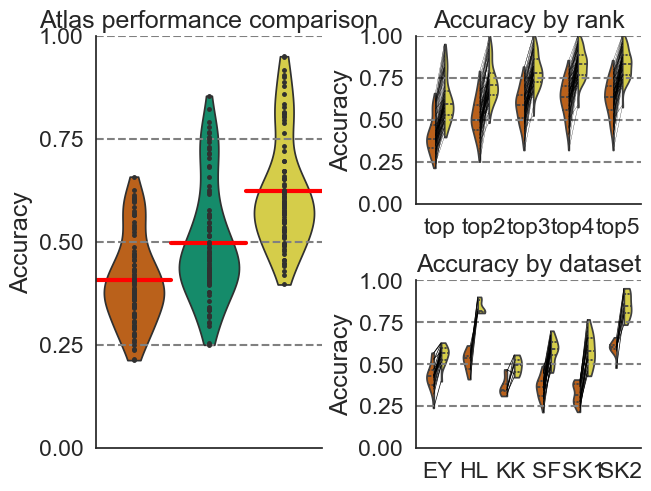

In [33]:
labels = ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2']
datasets = [EY_dataset,HL_dataset, KK_dataset, SF_dataset, SK1_dataset, SK2_dataset]

accs_base, accs_match, accs_full_nomatch, accs_fullmatch = gen_plots_acc(datasets, labels, skipfiles, accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full)

### Figures with all models

In [6]:
def get_accuracies(folder, atlas):
    acc_df = pd.DataFrame(columns=['top1', 'top2', 'top3', 'top4', 'top5', 'Filename'])
    neur_ID_df = pd.DataFrame(columns=['Total_neurons','Percent_IDd', 'Num_labels', 'Filename'])
    for file in os.listdir(folder):
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        df, costs = run_linear_assignment(df_data, atlas)

        IDd = df[~df['ID'].isnull()]

        per_ID = len(IDd.index)/len(df.index)

        total_neurons = len(df.index)

        corr1 = df.loc[df['ID']==df['assign_1']]
        corr2 = df.loc[df['ID']==df['assign_2']]
        corr3 = df.loc[df['ID']==df['assign_3']]
        corr4 = df.loc[df['ID']==df['assign_4']]
        corr5 = df.loc[df['ID']==df['assign_5']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)
        corr_cum_5 = pd.concat([corr_cum_4, corr5]).drop_duplicates().reset_index(drop=True)

        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)
        per_corr_5 = len(corr_cum_5.index)/len(IDd.index)

        acc_df.loc[len(acc_df.index)] = [per_corr_1, per_corr_2, per_corr_3, per_corr_4, per_corr_5, file[:-4]]
        neur_ID_df.loc[len(neur_ID_df.index)] = [total_neurons, per_ID,total_neurons*per_ID, file[:-4]]

    return acc_df, neur_ID_df

In [55]:
'''
Get accuracy values for each dataset using the trained atlas and the roughly aligned point clouds. If you would like
to test on datasets that have not been pre-aligned, please use the neuroPAL_ID software which has the atlas and alignment
code pre-compiled
'''

NP_atlas_match = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_NPonly.pkl') #Atlas trained on just original 10 NeuroPAL datasets
NP_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_NPunmatch.pkl')

accs_stat_NP, neur_ID_use = get_accuracies('../data/aligned_heads/aligned_NP', NP_atlas_match)
accs_stat_NP_unmatch, neur_ID = get_accuracies('../data/aligned_heads/aligned_NP_nomatch', NP_atlas_unmatch)

In [56]:
for i in range(5):
    full_atlas_match = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_split/exgroup'+str(i)+'.pkl') 
    full_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_split_unmatch/exgroup'+str(i)+'.pkl')

    accs_match, neur_ID = get_accuracies('../data/aligned_heads/aligned_split/group'+str(i+1), full_atlas_match)
    accs_unmatch, neur_ID = get_accuracies('../data/aligned_heads/aligned_split_nomatch/group'+str(i+1), full_atlas_unmatch)

    if i==0:
        accs_stat_full = accs_match
        accs_stat_full_unmatch = accs_unmatch
    else:
        accs_stat_full = pd.concat([accs_stat_full, accs_match])
        accs_stat_full_unmatch = pd.concat([accs_stat_full_unmatch, accs_unmatch])

In [57]:
datasets = ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2']

accs_stat_dataset = None

for dataset in datasets:
    data_atlas_match = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_06_23_dataset_split/ex'+dataset+'.pkl')

    accs_data_match, neur_ID = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_2024_06_23/aligned_dataset_split/'+dataset, data_atlas_match)

    if accs_stat_dataset is None:
        accs_stat_dataset = accs_data_match
    else:
        accs_stat_dataset = pd.concat([accs_stat_dataset, accs_data_match])

In [58]:
accs_CRF_NP_unmatch = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CRFID/original.csv')
accs_CRF_NP = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CRFID/colorcorr.csv')
accs_CRF_full = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CRFID/multi_colorcorr.csv')

In [59]:
accs_CPD_NP_nomatch = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CPD/nomatch_NP_temp.csv')
accs_CPD_NP = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CPD/match_NP_temp.csv')
accs_CPD_full = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CPD/match_all_temp.csv')

In [65]:
accs_dfs = [accs_CPD_NP_nomatch, accs_CPD_NP, accs_CPD_full, accs_stat_NP_unmatch, accs_stat_NP, accs_stat_full, accs_CRF_NP_unmatch, accs_CRF_NP, accs_CRF_full]
labels = ['CPD (base)', 'CPD (color corrected)', 'CPD (full color corrected)', 'StatAtlas (base)', 'StatAtlas (color corrected)', 'StatAtlas (retrained)', 'CRFID (base)', 'CRFID (color corrected)', 'CRFID (retrained)']
atlases = ['Original', 'Color corrected', 'Multi-lab + color corrected', 'Original', 'Color corrected', 'Multi-lab + color corrected', 'Original', 'Color corrected', 'Multi-lab + color corrected']
models = ['CPD', 'CPD', 'CPD', 'StatAtlas', 'StatAtlas', 'StatAtlas', 'CRFID', 'CRFID', 'CRFID']
neur_ID_df = neur_ID_use
group_csv = pd.read_csv('../data/group_assigns.csv')
dataset_files = {row['Filename']:row['Dataset'] for i, row in group_csv.iterrows()}

In [67]:
def gen_plots(accs_dfs, neur_ID_df, labels, atlases, models, dataset_files, skipfiles):

    plt.rcParams.update({'font.size': 60})
    sns.set(style='white', font_scale=1.5)

    filenames = accs_dfs[0]['Filename']

    df_dataset = pd.DataFrame(columns = ['Filename', 'Dataset','Label', 'Atlas', 'Model', 'Accuracy', 'Rank', 'Num_labeled'])
    thresh = 100

    for file in filenames:
        if file in skipfiles:
            continue

        for i, df in enumerate(accs_dfs):
            acc = df.loc[df['Filename']==file]
            ID_df = neur_ID_df.loc[neur_ID_df['Filename']==file]

            num_label = ID_df.iloc[0]['Num_labels']
            dataset = dataset_files[file]

            for j in range(1,6):
                df_dataset.loc[len(df_dataset.index)] = [file, dataset,labels[i], atlases[i], models[i], acc.iloc[0]['top'+str(j)], j, num_label]


    for label in labels:
        print(label + ': low labels')
        print('Rank 1 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print('Rank 5 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print(label + ': high labels')
        print('Rank 1 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print('Rank 5 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print(label + ': laverage')
        print('Rank 1 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)]['Accuracy'])))
        print('Rank 5 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)]['Accuracy'])))

    
    for rank in [1,5]:
        print('For rank {0}'.format(rank))
        consol_match_comparisons = {}
        for model in set(models):
            df_model = df_dataset[(df_dataset['Model']==model) & (df_dataset['Rank']==rank)]
            base_accs = np.asarray(df_model[df_model['Atlas']=='Original']['Accuracy'])
            match_accs = np.asarray(df_model[df_model['Atlas']=='Color corrected']['Accuracy'])
            consol_match_accs = np.asarray(df_model[df_model['Atlas']=='Multi-lab + color corrected']['Accuracy'])

            base_match_pairs = np.asarray(match_accs - base_accs)
            base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)
            match_fullmatch_pairs = np.asarray(consol_match_accs - match_accs)

            base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))),np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]
            base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]
            match_fullmatch_CI = [np.mean(match_fullmatch_pairs)-2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs))),np.mean(match_fullmatch_pairs)+2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs)))]

            base_match = scipy.stats.ttest_rel(base_accs, match_accs)
            base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
            match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)

            base_match_string = 'original (10 worms) no color correction versus with color correction'
            base_fullmatch_string = 'original with no color correction versus multi-lab with color correction'
            match_fullmatch_string = 'original with color correction versus multi-lab with color correction'

            print_string = '{0} - mean effect size = {1:.2%},95% CI effect size = [{2:.2%}, {3:.2%}], p = {4:.3e}'

            print(model + ': '+print_string.format(base_match_string, np.mean(base_match_pairs), base_match_CI[0], base_match_CI[1], base_match.pvalue)+'; ' + print_string.format(base_fullmatch_string, np.mean(base_fullmatch_pairs), base_fullmatch_CI[0], base_fullmatch_CI[1], base_fullmatch.pvalue)+'; '+ print_string.format(match_fullmatch_string, np.mean(match_fullmatch_pairs), match_fullmatch_CI[0], match_fullmatch_CI[1], match_fullmatch.pvalue)+'.')

            consol_match_comparisons[model] = consol_match_accs

        for model1, vals1 in consol_match_comparisons.items():
            for model2, vals2 in consol_match_comparisons.items():
                if model1 == model2 :
                    continue

                pairs = np.asarray(vals2-vals1)
                CI = [np.mean(pairs)-2*(np.std(pairs)/np.sqrt(len(pairs))),np.mean(pairs)+2*(np.std(pairs)/np.sqrt(len(pairs)))]
                stats = scipy.stats.ttest_rel(vals1, vals2)

                print_string = '{0} multi-lab color corrected versus {1} multi-lab color corrected - mean effect size = {2:.2%},95% CI effect size = [{3:.2%}, {4:.2%}], p = {5:.3e}.'
                print(print_string.format(model1, model2, np.mean(pairs), CI[0], CI[1], stats.pvalue))

    fig, axs = plt.subplots(2,1, sharex=True)

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    sns.violinplot(ax = axs[0], data=df_dataset[df_dataset['Rank']==1], x='Label', y='Accuracy', hue='Atlas', palette =[color1, color2, color4], cut=0, inner='point', density_norm='width', inner_kws = {})
    sns.violinplot(ax = axs[1], data=df_dataset[df_dataset['Rank']==5], x='Label', y='Accuracy', hue='Atlas', palette =[color1, color2, color4], cut=0, inner='point', density_norm='width', inner_kws = {})

    df_rank = df_dataset[df_dataset['Rank']==1]
    df_rank5 = df_dataset[df_dataset['Rank']==5]

    stats = df_rank.groupby('Label')['Accuracy'].agg(['mean']).reset_index()
    stats5 = df_rank5.groupby('Label')['Accuracy'].agg(['mean']).reset_index()

    for i, row in stats.iterrows():
        cat_index = np.where(df_rank['Label'].unique() == row['Label'])[0][0]
        axs[0].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_rank['Label'].unique()), xmax=(cat_index+1)/len(df_rank['Label'].unique()))

    for i, row in stats5.iterrows():
        cat_index = np.where(df_rank5['Label'].unique() == row['Label'])[0][0]
        axs[1].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_rank5['Label'].unique()), xmax=(cat_index+1)/len(df_rank5['Label'].unique()))

    axs[0].set_ylim((0,1.2))
    axs[0].set(xlabel=None)
    axs[0].set_title('Model performance: top ranked assignment')
    axs[0].set_yticks([0,0.25,0.5,0.75,1.0])
    axs[0].legend([],[], frameon=False)
    axs[0].set_xticklabels([])

    axs[1].set_ylim((0,1.2))
    axs[1].set(xlabel=None)
    axs[1].set_title('Model performance: top 5 assignments')
    axs[1].set_yticks([0,0.25,0.5,0.75,1.0])
    axs[1].legend([],[], frameon=False)
    axs[1].set_xticklabels([])

    axs[0].spines[['right', 'top']].set_visible (False)
    axs[0].axhline(1.0, ls='--', c='grey')
    axs[0].axhline(0.75, ls='--', c='grey')
    axs[0].axhline(0.5, ls='--', c='grey')
    axs[0].axhline(0.25, ls='--', c='grey')

    axs[1].spines[['right', 'top']].set_visible (False)
    axs[1].axhline(1.0, ls='--', c='grey')
    axs[1].axhline(0.75, ls='--', c='grey')
    axs[1].axhline(0.5, ls='--', c='grey')
    axs[1].axhline(0.25, ls='--', c='grey')

    plt.show()

    return df_dataset

df_dataset = gen_plots(accs_dfs, neur_ID_df, labels, atlases, models, dataset_files, skipfiles)



CPD (base): low labels
Rank 1 mean and std
0.11069407869012962
0.07419048423171938
Rank 5 mean and std
0.2806168107798942
0.11968626727938254
CPD (base): high labels
Rank 1 mean and std
0.43221373408316827
0.08595070400241392
Rank 5 mean and std
0.7281772713548796
0.04971708170005544
CPD (base): laverage
Rank 1 mean and std
0.20988631280074796
0.16774503953730482
Rank 5 mean and std
0.41869397414877274
0.23108569262680317
CPD (color corrected): low labels
Rank 1 mean and std
0.22874033838671037
0.16958991370606363
Rank 5 mean and std
0.4682367087787946
0.21531570928838462
CPD (color corrected): high labels
Rank 1 mean and std
0.41590165324476913
0.07714103516452378
Rank 5 mean and std
0.7170744773280382
0.055417801220370044
CPD (color corrected): laverage
Rank 1 mean and std
0.2864815950982392
0.1708697987328037
Rank 5 mean and std
0.5450058075865398
0.21497690949831388
CPD (full color corrected): low labels
Rank 1 mean and std
0.3850112050363181
0.1535105216395126
Rank 5 mean and std


In [62]:
models_order = ['CPD', 'StatAtlas', 'CRFID']
order = ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2']

In [63]:
df_dataset['Dataset'].unique()

array(['HL', 'SF', 'SK1', 'KK', 'SK2', 'EY'], dtype=object)

In [68]:
%matplotlib qt
def gen_plots_bydataset(df_dataset, models, order):
    
    plt.rcParams.update({'font.size': 60})
    sns.set(style='white', font_scale=1.5)

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]
    
    fig, axs = plt.subplots(len(models),2)

    for i, model in enumerate(models):
        df_model = df_dataset[(df_dataset['Model']==model) & (df_dataset['Rank']==1)]
        df_model_full = df_model[(df_model['Atlas']=='Original') | (df_model['Atlas']=='Multi-lab + color corrected')]
        df_model_color = df_model[(df_model['Atlas']=='Original') | (df_model['Atlas']=='Color corrected')]
        sns.violinplot(ax=axs[i,1], data = df_model_full, x='Dataset', y='Accuracy', hue='Atlas', palette=[color1, color4], gap=0.5, orient='v', split=True, cut=0, inner='quart', density_norm='width', order=order)
        sns.violinplot(ax=axs[i,0], data = df_model_color, x='Dataset', y='Accuracy', hue='Atlas', palette=[color1, color2], gap=0.5, orient='v', split=True, cut=0, inner='quart', density_norm='width', order =order)

        print('For {0} :'.format(model))
        for j, dataset in enumerate(sorted(df_model['Dataset'].unique())):
            df_data = df_model[df_model['Dataset']==dataset]
            for a, b, c in zip(df_data[df_data['Atlas']=='Original']['Accuracy'], df_data[df_data['Atlas']=='Multi-lab + color corrected']['Accuracy'], df_data[df_data['Atlas']=='Color corrected']['Accuracy']):
                axs[i,1].plot([j-0.1,j+0.1], [a,b], color='black', linewidth=0.5, label='_nolegend_')
                axs[i,0].plot([j-0.1,j+0.1], [a,c], color='black', linewidth=0.5, label='_nolegend_')

            base_accs = np.asarray(df_data[df_data['Atlas']=='Original']['Accuracy'])
            match_accs = np.asarray(df_data[df_data['Atlas']=='Color corrected']['Accuracy'])
            consol_match_accs = np.asarray(df_data[df_data['Atlas']=='Multi-lab + color corrected']['Accuracy'])
            
            base_match_pairs = np.asarray(match_accs - base_accs)
            base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)
            match_fullmatch_pairs = np.asarray(consol_match_accs - match_accs)

            base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))),np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]
            base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]
            match_fullmatch_CI = [np.mean(match_fullmatch_pairs)-2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs))),np.mean(match_fullmatch_pairs)+2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs)))]

            base_match = scipy.stats.ttest_rel(base_accs, match_accs)
            base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
            match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)

            base_match_string = 'original (10 worms) no color correction versus with color correction'
            base_fullmatch_string = 'original with no color correction versus multi-lab with color correction'

            print_string = '{0} - mean effect size = {1:.2%},95% CI effect size = [{2:.2%}, {3:.2%}], p = {4:.3e}'

            print('{0} dataset: '.format(dataset))
            print(print_string.format(base_match_string, np.mean(base_match_pairs), base_match_CI[0], base_match_CI[1], base_match.pvalue)+'; '+print_string.format(base_fullmatch_string, np.mean(base_fullmatch_pairs), base_fullmatch_CI[0], base_fullmatch_CI[1], base_fullmatch.pvalue)+'.')

        #axs[i,0].set_title(model)
        #axs[i,1].set_title(model)

        axs[i,0].set_ylim((0,1))
        axs[i,0].legend([],[], frameon=False)
        axs[i,0].set_xlabel(None)
        axs[i,0].set_ylabel(model)
        #axs[i,0].set_title('Accuracy by rank')
        axs[i,0].set_yticks([0,0.25,0.5,0.75,1.0])
        axs[i,1].set_ylim((0,1))
        axs[i,1].legend([],[], frameon=False)
        axs[i,1].set_xlabel(None)
        #axs[i,1].set_title('Accuracy by rank')
        axs[i,1].set_yticks([])
        axs[i,1].set_ylabel('')

        if i != len(models)-1:
            axs[i,0].set_xticks([])
            axs[i,1].set_xticks([])

        axs[i,0].spines[['right', 'top']].set_visible (False)
        axs[i,0].axhline(1.0, ls='--', c='grey')
        axs[i,0].axhline(0.75, ls='--', c='grey')
        axs[i,0].axhline(0.5, ls='--', c='grey')
        axs[i,0].axhline(0.25, ls='--', c='grey')
        axs[i,1].spines[['right', 'top']].set_visible (False)
        axs[i,1].axhline(1.0, ls='--', c='grey')
        axs[i,1].axhline(0.75, ls='--', c='grey')
        axs[i,1].axhline(0.5, ls='--', c='grey')
        axs[i,1].axhline(0.25, ls='--', c='grey')

    fig.suptitle('Accuracy by dataset')


    plt.show()

gen_plots_bydataset(df_dataset, models_order, order)




For CPD :
EY dataset: 
original (10 worms) no color correction versus with color correction - mean effect size = -2.00%,95% CI effect size = [-3.60%, -0.39%], p = 2.491e-02; original with no color correction versus multi-lab with color correction - mean effect size = -6.59%,95% CI effect size = [-10.85%, -2.34%], p = 6.695e-03.
HL dataset: 
original (10 worms) no color correction versus with color correction - mean effect size = 33.75%,95% CI effect size = [27.57%, 39.93%], p = 6.815e-06; original with no color correction versus multi-lab with color correction - mean effect size = 37.66%,95% CI effect size = [29.39%, 45.94%], p = 2.624e-05.
KK dataset: 
original (10 worms) no color correction versus with color correction - mean effect size = -0.67%,95% CI effect size = [-3.01%, 1.67%], p = 6.075e-01; original with no color correction versus multi-lab with color correction - mean effect size = 1.42%,95% CI effect size = [-1.58%, 4.43%], p = 4.041e-01.
SF dataset: 
original (10 worms) no

In [119]:
def gen_plots_byrank(df_dataset, models):

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]
    
    fig, axs = plt.subplots(len(models),2)

    for i, model in enumerate(models):
        df_model = df_dataset[(df_dataset['Model']==model)]
        df_model_full = df_model[(df_model['Atlas']=='Original') | (df_model['Atlas']=='Multi-lab + color corrected')]
        df_model_color = df_model[(df_model['Atlas']=='Original') | (df_model['Atlas']=='Color corrected')]
        sns.violinplot(ax=axs[i,1], data = df_model_full, x='Rank', y='Accuracy', hue='Atlas', palette=[color1, color4], gap=0.5, orient='v', split=True, cut=0, inner='quart', density_norm='width')
        sns.violinplot(ax=axs[i,0], data = df_model_color, x='Rank', y='Accuracy', hue='Atlas', palette=[color1, color2], gap=0.5, orient='v', split=True, cut=0, inner='quart', density_norm='width')


        print(f'{model}: original (10 worms) no color correction versus with color correction')
        for rank in range(1,6):
            df_rank = df_model[df_model['Rank']==rank]
            for a, b, c in zip(df_rank[df_rank['Atlas']=='Original']['Accuracy'], df_rank[df_rank['Atlas']=='Multi-lab + color corrected']['Accuracy'], df_rank[df_rank['Atlas']=='Color corrected']['Accuracy']):
                axs[i,1].plot([rank-1-0.1,rank-1+0.1], [a,b], color='black', linewidth=0.5, label='_nolegend_')
                axs[i,0].plot([rank-1-0.1,rank-1+0.1], [a,c], color='black', linewidth=0.5, label='_nolegend_')

            base_accs = np.asarray(df_rank[df_rank['Atlas']=='Original']['Accuracy'])
            match_accs = np.asarray(df_rank[df_rank['Atlas']=='Color corrected']['Accuracy'])
            
            base_match_pairs = np.asarray(match_accs - base_accs)

            base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))),np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]

            base_match = scipy.stats.ttest_rel(base_accs, match_accs)

            print_string = 'top{0} - mean effect size = {1:.2%},95% CI effect size = [{2:.2%}, {3:.2%}], p = {4:.3e}'
            print(print_string.format(rank, np.mean(base_match_pairs), base_match_CI[0], base_match_CI[1], base_match.pvalue))

        print(f'{model}: original with no color correction versus multi-lab with color correction')
        for rank in range(1,6):    
            df_rank = df_model[df_model['Rank']==rank]
            base_accs = np.asarray(df_rank[df_rank['Atlas']=='Original']['Accuracy'])
            consol_match_accs = np.asarray(df_rank[df_rank['Atlas']=='Multi-lab + color corrected']['Accuracy'])
            
            base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)

            base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]
            base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)

            print_string = 'top{0} - mean effect size = {1:.2%},95% CI effect size = [{2:.2%}, {3:.2%}], p = {4:.3e}'
            print(print_string.format(rank, np.mean(base_fullmatch_pairs), base_fullmatch_CI[0], base_fullmatch_CI[1], base_fullmatch.pvalue))


        #axs[i,0].set_title(model)
        #axs[i,1].set_title(model)

        axs[i,0].set_ylim((0,1))
        axs[i,0].legend([],[], frameon=False)
        axs[i,0].set_xlabel(None)
        axs[i,0].set_ylabel(model)
        #axs[i,0].set_title('Accuracy by rank')
        axs[i,0].set_yticks([0,0.25,0.5,0.75,1.0])
        axs[i,1].set_ylim((0,1))
        axs[i,1].legend([],[], frameon=False)
        axs[i,1].set_xlabel(None)
        #axs[i,1].set_title('Accuracy by rank')
        axs[i,1].set_yticks([])
        axs[i,1].set_ylabel('')

        if i != len(models)-1:
            axs[i,0].set_xticks([])
            axs[i,1].set_xticks([])
        else:
            axs[i,0].set_xticklabels(['top1', 'top2', 'top3', 'top4', 'top5'])
            axs[i,1].set_xticklabels(['top1', 'top2', 'top3', 'top4', 'top5'])

        axs[i,0].spines[['right', 'top']].set_visible (False)
        axs[i,0].axhline(1.0, ls='--', c='grey')
        axs[i,0].axhline(0.75, ls='--', c='grey')
        axs[i,0].axhline(0.5, ls='--', c='grey')
        axs[i,0].axhline(0.25, ls='--', c='grey')
        axs[i,1].spines[['right', 'top']].set_visible (False)
        axs[i,1].axhline(1.0, ls='--', c='grey')
        axs[i,1].axhline(0.75, ls='--', c='grey')
        axs[i,1].axhline(0.5, ls='--', c='grey')
        axs[i,1].axhline(0.25, ls='--', c='grey')

    fig.suptitle('Accuracy by rank')


    plt.show()

gen_plots_byrank(df_dataset, models_order)

CPD: original (10 worms) no color correction versus with color correction
top1 - mean effect size = 7.66%,95% CI effect size = [5.07%, 10.25%], p = 6.298e-08
top2 - mean effect size = 10.28%,95% CI effect size = [7.42%, 13.14%], p = 2.018e-10
top3 - mean effect size = 11.52%,95% CI effect size = [8.55%, 14.49%], p = 1.252e-11
top4 - mean effect size = 12.34%,95% CI effect size = [9.16%, 15.52%], p = 1.326e-11
top5 - mean effect size = 12.63%,95% CI effect size = [9.41%, 15.85%], p = 8.959e-12
CPD: original with no color correction versus multi-lab with color correction
top1 - mean effect size = 17.62%,95% CI effect size = [13.60%, 21.63%], p = 9.881e-14
top2 - mean effect size = 21.80%,95% CI effect size = [17.31%, 26.28%], p = 1.047e-15
top3 - mean effect size = 22.64%,95% CI effect size = [18.03%, 27.25%], p = 6.539e-16
top4 - mean effect size = 23.21%,95% CI effect size = [18.50%, 27.91%], p = 5.260e-16
top5 - mean effect size = 23.44%,95% CI effect size = [18.71%, 28.17%], p = 4.11

/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_4727/3588004318.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,0].set_xticklabels(['top1', 'top2', 'top3', 'top4', 'top5'])
/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_4727/3588004318.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_xticklabels(['top1', 'top2', 'top3', 'top4', 'top5'])


In [127]:
def gen_plots_byquartile(df_dataset, models):
    neur_quartiles = np.quantile(df_dataset[(df_dataset['Rank']==1) & (df_dataset['Label']=='CPD (base)')]['Num_labeled'], [0,0.25,0.5,0.75,1])

    print(neur_quartiles)

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    fig, axs = plt.subplots(len(models), 4)

    for i, model in enumerate(models):
        print(f'{model}:')
        df_model = df_dataset[(df_dataset['Model']==model)&(df_dataset['Rank']==1)]
        sns.violinplot(ax=axs[i,0], data = df_model[df_model['Num_labeled']<np.round(neur_quartiles[1])], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], gap=0.5, orient='v', cut=0, inner='quart', density_norm='width')
        sns.violinplot(ax=axs[i,1], data = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[1]))&(df_model['Num_labeled']<np.round(neur_quartiles[2]))], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], gap=0.5, orient='v', cut=0, inner='quart', density_norm='width')
        sns.violinplot(ax=axs[i,2], data = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[2]))&(df_model['Num_labeled']<np.round(neur_quartiles[3]))], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], gap=0.5, orient='v', cut=0, inner='quart', density_norm='width')
        sns.violinplot(ax=axs[i,3], data = df_model[df_model['Num_labeled']>=np.round(neur_quartiles[3])], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], gap=0.5, orient='v', cut=0, inner='quart', density_norm='width')


        for quartile in ['1st quartile', '2nd quartile', '3rd quartile', '4th quartile']:
            print(f'{quartile}:')
            if quartile == '1st quartile':
                df_quartile = df_model[df_model['Num_labeled']<np.round(neur_quartiles[1])]
            elif quartile == '2nd quartile':
                df_quartile = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[1]))&(df_model['Num_labeled']<np.round(neur_quartiles[2]))]
            elif quartile == '3rd quartile':
                df_quartile = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[2]))&(df_model['Num_labeled']<np.round(neur_quartiles[3]))]
            else:
                df_quartile = df_model[df_model['Num_labeled']>=np.round(neur_quartiles[3])]

            base_accs = np.asarray(df_quartile[df_quartile['Atlas']=='Original']['Accuracy'])
            match_accs = np.asarray(df_quartile[df_quartile['Atlas']=='Color corrected']['Accuracy'])
            consol_match_accs = np.asarray(df_quartile[df_quartile['Atlas']=='Multi-lab + color corrected']['Accuracy'])
            
            base_match_pairs = np.asarray(match_accs - base_accs)
            base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)
            match_fullmatch_pairs = np.asarray(consol_match_accs - match_accs)

            base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))),np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]
            base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]
            match_fullmatch_CI = [np.mean(match_fullmatch_pairs)-2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs))),np.mean(match_fullmatch_pairs)+2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs)))]

            base_match = scipy.stats.ttest_rel(base_accs, match_accs)
            base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
            match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)

            base_match_string = 'original (10 worms) no color correction versus with color correction'
            base_fullmatch_string = 'original with no color correction versus multi-lab with color correction'
            match_fullmatch_string = 'original with color correction versus multi-lab with color correction'

            print_string = '{0} - mean effect size = {1:.2%},95% CI effect size = [{2:.2%}, {3:.2%}], p = {4:.3e}'

            print(print_string.format(base_match_string, np.mean(base_match_pairs), base_match_CI[0], base_match_CI[1], base_match.pvalue)+'; '+print_string.format(base_fullmatch_string, np.mean(base_fullmatch_pairs), base_fullmatch_CI[0], base_fullmatch_CI[1], base_fullmatch.pvalue)+'; '+print_string.format(match_fullmatch_string, np.mean(match_fullmatch_pairs), match_fullmatch_CI[0], match_fullmatch_CI[1], match_fullmatch.pvalue)+'.')

        
        for j in range(4):

            axs[i,j].set_ylim((0,1))
            axs[i,j].legend([],[], frameon=False)
            axs[i,j].set_xlabel(None)
            if j==0:
                axs[i,j].set_ylabel(model)
            else:
                axs[i,j].set_ylabel('')
            #axs[i,0].set_title('Accuracy by rank')
            axs[i,j].set_yticks([0,0.25,0.5,0.75,1.0])
            axs[i,j].set_title('')
            axs[i,j].set_xticks([])

            axs[i,j].spines[['right', 'top']].set_visible (False)
            axs[i,j].axhline(1.0, ls='--', c='grey')
            axs[i,j].axhline(0.75, ls='--', c='grey')
            axs[i,j].axhline(0.5, ls='--', c='grey')
            axs[i,j].axhline(0.25, ls='--', c='grey')


    fig.suptitle('Accuracy by # of ground truth labels')

    axs[0,0].set_title('1st quartile: '+'0-'+str(int(neur_quartiles[1])))
    axs[0,1].set_title('2nd quartile: '+str(int(neur_quartiles[1]))+'-'+str(int(neur_quartiles[2])))
    axs[0,2].set_title('3rd quartile: '+str(int(neur_quartiles[2]))+'-'+str(int(neur_quartiles[3])))
    axs[0,3].set_title('4th quartile: '+str(int(neur_quartiles[3]))+'-'+str(int(neur_quartiles[4])))

    plt.show()

gen_plots_byquartile(df_dataset, models_order)

        
        

[ 33.    53.25  69.   155.5  184.  ]
CPD:


1st quartile:
original (10 worms) no color correction versus with color correction - mean effect size = 11.11%,95% CI effect size = [7.25%, 14.96%], p = 1.162e-05; original with no color correction versus multi-lab with color correction - mean effect size = 24.40%,95% CI effect size = [18.20%, 30.61%], p = 1.124e-07; original with color correction versus multi-lab with color correction - mean effect size = 13.30%,95% CI effect size = [7.85%, 18.74%], p = 9.123e-05.
2nd quartile:
original (10 worms) no color correction versus with color correction - mean effect size = 17.21%,95% CI effect size = [10.39%, 24.03%], p = 6.144e-05; original with no color correction versus multi-lab with color correction - mean effect size = 32.96%,95% CI effect size = [27.42%, 38.49%], p = 7.032e-11; original with color correction versus multi-lab with color correction - mean effect size = 15.74%,95% CI effect size = [8.48%, 23.00%], p = 3.335e-04.
3rd quartile:
original (10 worms) no color correction versu

In [130]:
def gen_plots_byquartile_rank(df_dataset, models):
    neur_quartiles = np.quantile(df_dataset[(df_dataset['Rank']==1) & (df_dataset['Label']=='CPD (base)')]['Num_labeled'], [0,0.25,0.5,0.75,1])

    print(neur_quartiles)

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    fig, axs = plt.subplots(len(models), 4)

    for i, model in enumerate(models):
        print(f'{model}:')
        df_model = df_dataset[(df_dataset['Model']==model)&((df_dataset['Atlas']=='Original')|(df_dataset['Atlas']=='Multi-lab + color corrected'))]
        sns.violinplot(ax=axs[i,0], data = df_model[df_model['Num_labeled']<np.round(neur_quartiles[1])], x='Rank', y='Accuracy', hue='Atlas', palette=[color1, color4], gap=0.5, split=True, orient='v', cut=0, inner='quart', density_norm='width')
        sns.violinplot(ax=axs[i,1], data = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[1]))&(df_model['Num_labeled']<np.round(neur_quartiles[2]))], x='Rank', y='Accuracy', hue='Atlas', palette=[color1, color4], gap=0.5, split=True, orient='v', cut=0, inner='quart', density_norm='width')
        sns.violinplot(ax=axs[i,2], data = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[2]))&(df_model['Num_labeled']<np.round(neur_quartiles[3]))], x='Rank', y='Accuracy', hue='Atlas', palette=[color1, color4], gap=0.5, split=True, orient='v', cut=0, inner='quart', density_norm='width')
        sns.violinplot(ax=axs[i,3], data = df_model[df_model['Num_labeled']>=np.round(neur_quartiles[3])], x='Rank', y='Accuracy', hue='Atlas', palette=[color1, color4], gap=0.5, split=True, orient='v', cut=0, inner='quart', density_norm='width')


        for quartile in ['1st quartile', '2nd quartile', '3rd quartile', '4th quartile']:
            print(f'{quartile}:')
            if quartile == '1st quartile':
                df_quartile = df_model[df_model['Num_labeled']<np.round(neur_quartiles[1])]
            elif quartile == '2nd quartile':
                df_quartile = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[1]))&(df_model['Num_labeled']<np.round(neur_quartiles[2]))]
            elif quartile == '3rd quartile':
                df_quartile = df_model[(df_model['Num_labeled']>=np.round(neur_quartiles[2]))&(df_model['Num_labeled']<np.round(neur_quartiles[3]))]
            else:
                df_quartile = df_model[df_model['Num_labeled']>=np.round(neur_quartiles[3])]

            for rank in np.arange(1,6):
                df_rank = df_quartile[df_quartile['Rank']==rank]

                base_accs = np.asarray(df_rank[df_rank['Atlas']=='Original']['Accuracy'])
                consol_match_accs = np.asarray(df_rank[df_rank['Atlas']=='Multi-lab + color corrected']['Accuracy'])
                
                base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)

                base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]

                base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)

                print_string = 'top{0} - mean effect size = {1:.2%},95% CI effect size = [{2:.2%}, {3:.2%}], p = {4:.3e}'

                print(print_string.format(rank, np.mean(base_fullmatch_pairs), base_fullmatch_CI[0], base_fullmatch_CI[1], base_fullmatch.pvalue))

        for j in range(4):

            for rank in range(1,6):
                df_rank = df_model[df_model['Rank']==rank]
                for a, b, c in zip(df_rank[df_rank['Atlas']=='Base']['Accuracy'], df_rank[df_rank['Atlas']=='Full color corrected']['Accuracy'], df_rank[df_rank['Atlas']=='Color corrected']['Accuracy']):
                    axs[i,j].plot([rank-1-0.1,rank-1+0.1], [a,b], color='black', linewidth=0.5, label='_nolegend_')

            axs[i,j].set_ylim((0,1))
            axs[i,j].legend([],[], frameon=False)
            axs[i,j].set_xlabel(None)
            if j==0:
                axs[i,j].set_ylabel(model)
            else:
                axs[i,j].set_ylabel('')
            #axs[i,0].set_title('Accuracy by rank')
            axs[i,j].set_yticks([0,0.25,0.5,0.75,1.0])
            axs[i,j].set_title('')
            if not i == len(models)-1:
                axs[i,j].set_xticks([])
            else:
                axs[i,j].set_xticklabels(['top1', 'top2', 'top3', 'top4', 'top5'])

            axs[i,j].spines[['right', 'top']].set_visible (False)
            axs[i,j].axhline(1.0, ls='--', c='grey')
            axs[i,j].axhline(0.75, ls='--', c='grey')
            axs[i,j].axhline(0.5, ls='--', c='grey')
            axs[i,j].axhline(0.25, ls='--', c='grey')

    fig.suptitle('Ranked accuracy by # of ground truth labels')

    axs[0,0].set_title('1st quartile: '+'0-'+str(int(neur_quartiles[1])))
    axs[0,1].set_title('2nd quartile: '+str(int(neur_quartiles[1]))+'-'+str(int(neur_quartiles[2])))
    axs[0,2].set_title('3rd quartile: '+str(int(neur_quartiles[2]))+'-'+str(int(neur_quartiles[3])))
    axs[0,3].set_title('4th quartile: '+str(int(neur_quartiles[3]))+'-'+str(int(neur_quartiles[4])))

    plt.show()

gen_plots_byquartile_rank(df_dataset, models_order)

[ 33.    53.25  69.   155.5  184.  ]
CPD:


1st quartile:
top1 - mean effect size = 24.40%,95% CI effect size = [18.20%, 30.61%], p = 1.124e-07
top2 - mean effect size = 33.12%,95% CI effect size = [27.39%, 38.86%], p = 1.250e-10
top3 - mean effect size = 34.51%,95% CI effect size = [29.51%, 39.51%], p = 3.980e-12
top4 - mean effect size = 34.70%,95% CI effect size = [29.53%, 39.87%], p = 6.885e-12
top5 - mean effect size = 35.63%,95% CI effect size = [30.26%, 41.01%], p = 8.878e-12
2nd quartile:
top1 - mean effect size = 32.96%,95% CI effect size = [27.42%, 38.49%], p = 7.032e-11
top2 - mean effect size = 38.79%,95% CI effect size = [33.73%, 43.84%], p = 4.837e-13
top3 - mean effect size = 40.45%,95% CI effect size = [35.58%, 45.33%], p = 1.003e-13
top4 - mean effect size = 42.43%,95% CI effect size = [37.62%, 47.24%], p = 2.827e-14
top5 - mean effect size = 42.46%,95% CI effect size = [37.67%, 47.25%], p = 2.595e-14
3rd quartile:
top1 - mean effect size = 19.99%,95% CI effect size = [14.47%, 25.51%], p = 3.175e-07
top2 - mean 

/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_4727/529481721.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(['top1', 'top2', 'top3', 'top4', 'top5'])


## Supplement: dataset split

In [37]:

NP_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_NPunmatch.pkl')

accs_stat_NP_unmatch, neur_ID = get_accuracies('../data/aligned_heads/aligned_NP_nomatch', NP_atlas_unmatch)

for i in range(5):
    full_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_split_unmatch/exgroup'+str(i)+'.pkl')

    accs_unmatch, neur_ID = get_accuracies('../data/aligned_heads/aligned_split_nomatch/group'+str(i+1), full_atlas_unmatch)

    if i==0:
        accs_stat_full_unmatch = accs_unmatch
    else:
        accs_stat_full_unmatch = pd.concat([accs_stat_full_unmatch, accs_unmatch])

datasets = ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2']

accs_stat_dataset = None

for dataset in datasets:
    data_atlas_match = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_06_23_dataset_split/ex'+dataset+'.pkl')

    accs_data_match, neur_ID = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_2024_06_23/aligned_dataset_split/'+dataset, data_atlas_match)

    if accs_stat_dataset is None:
        accs_stat_dataset = accs_data_match
    else:
        accs_stat_dataset = pd.concat([accs_stat_dataset, accs_data_match])

In [38]:
accs_CRF_NP_unmatch = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CRFID/original.csv')
accs_CRF_dataset = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CRFID/leave_one_lab.csv')
accs_CRF_full = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CRFID/multi_colorcorr.csv')

accs_CPD_NP_nomatch = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CPD/nomatch_NP_temp.csv')
accs_CPD_dataset = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CPD/match_NP_temp.csv')
accs_CPD_full = pd.read_csv('/Users/danielysprague/foco_lab/data/Acc_CPD/match_leave_lab_out.csv')

In [44]:
accs_dfs = [accs_CPD_NP_nomatch, accs_CPD_dataset, accs_CPD_full, accs_stat_NP_unmatch, accs_stat_dataset, accs_stat_full, accs_CRF_NP_unmatch, accs_CRF_dataset, accs_CRF_full]
labels = ['CPD (original)', 'CPD (dataset split)', 'CPD (full corpus)', 'StatAtlas (origiinal)', 'StatAtlas (dataset split)','StatAtlas (full corpus)', 'CRFID (original)', 'CRFID (dataset split)', 'CRFID (full corpus)']
atlases = ['Original', 'Dataset split + color corrected', 'Multi-lab + color corrected', 'Original', 'Dataset split + color corrected', 'Multi-lab + color corrected', 'Original', 'Dataset split + color corrected', 'Multi-lab + color corrected']
models = ['CPD', 'CPD', 'CPD', 'StatAtlas', 'StatAtlas', 'StatAtlas', 'CRFID', 'CRFID', 'CRFID']
neur_ID_df = neur_ID_use
group_csv = pd.read_csv('../data/group_assigns.csv')
dataset_files = {row['Filename']:row['Dataset'] for i, row in group_csv.iterrows()}

In [54]:
%matplotlib qt
def gen_plot_dataset_split(accs_dfs, neur_ID_df, labels, atlases, models, dataset_files, skipfiles):

    plt.rcParams.update({'font.size': 60})
    sns.set(style='white', font_scale=1.5)

    filenames = accs_dfs[0]['Filename']

    df_dataset = pd.DataFrame(columns = ['Filename', 'Dataset','Label', 'Atlas', 'Model', 'Accuracy', 'Rank', 'Num_labeled'])
    thresh = 100

    for file in filenames:
        if file in skipfiles:
            continue

        for i, df in enumerate(accs_dfs):
            acc = df.loc[df['Filename']==file]
            ID_df = neur_ID_df.loc[neur_ID_df['Filename']==file]

            num_label = ID_df.iloc[0]['Num_labels']
            dataset = dataset_files[file]

            for j in range(1,6):
                df_dataset.loc[len(df_dataset.index)] = [file, dataset,labels[i], atlases[i], models[i], acc.iloc[0]['top'+str(j)], j, num_label]

    for label in labels:
        print(label + ': low labels')
        print('Rank 1 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print('Rank 5 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']<thresh)]['Accuracy'])))
        print(label + ': high labels')
        print('Rank 1 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print('Rank 5 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)&(df_dataset['Num_labeled']>=thresh)]['Accuracy'])))
        print(label + ': laverage')
        print('Rank 1 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==1)]['Accuracy'])))
        print('Rank 5 mean and std')
        print(np.mean(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)]['Accuracy'])))
        print(np.std(np.asarray(df_dataset[(df_dataset['Label']==label)&(df_dataset['Rank']==5)]['Accuracy'])))

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    fig, axs = plt.subplots(3,6, sharex=True)

    for l, model in enumerate(['CPD', 'StatAtlas', 'CRFID']):
        df_model = df_dataset[df_dataset['Model']==model] 

        print('{0}: '.format(model))
        for i, dataset in enumerate(sorted(df_dataset['Dataset'].unique())):
            df_data = df_model[df_model['Dataset']==dataset]

            sns.violinplot(ax = axs[l,i], data=df_data[df_data['Rank']==1], x='Atlas', y='Accuracy', hue='Atlas', palette =[color1, color3, color4], cut=0, inner='point', density_norm='width', inner_kws = {})
            #sns.violinplot(ax = axs[l*2+1,i], data=df_data[df_data['Rank']==5], x='Atlas', y='Accuracy', hue='Atlas', palette =[color1, color3, color4], cut=0, inner='point', density_norm='width', inner_kws = {})

            df_rank = df_data[df_data['Rank']==1]
            #df_rank5 = df_data[df_data['Rank']==5]

            stats = df_rank.groupby('Label')['Accuracy'].agg(['mean']).reset_index()
            #stats5 = df_rank5.groupby('Label')['Accuracy'].agg(['mean']).reset_index()

            
            for j, row in stats.iterrows():
                cat_index = np.where(df_rank['Label'].unique() == row['Label'])[0][0]
                axs[l,i].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_rank['Label'].unique()), xmax=(cat_index+1)/len(df_rank['Label'].unique()))

            #for j, row in stats5.iterrows():
            #    cat_index = np.where(df_rank5['Label'].unique() == row['Label'])[0][0]
            #    axs[l*2+1,i].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_rank5['Label'].unique()), xmax=(cat_index+1)/len(df_rank5['Label'].unique()))

            base_accs = np.asarray(df_rank[df_rank['Atlas']=='Original']['Accuracy'])
            match_accs = np.asarray(df_rank[df_rank['Atlas']=='Dataset split + color corrected']['Accuracy'])
            consol_match_accs = np.asarray(df_rank[df_rank['Atlas']=='Multi-lab + color corrected']['Accuracy'])
            
            base_match_pairs = np.asarray(match_accs - base_accs)
            base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)
            match_fullmatch_pairs = np.asarray(consol_match_accs - match_accs)

            base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))),np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]
            base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]
            match_fullmatch_CI = [np.mean(match_fullmatch_pairs)-2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs))),np.mean(match_fullmatch_pairs)+2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs)))]

            base_match = scipy.stats.ttest_rel(base_accs, match_accs)
            base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
            match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)

            base_match_string = 'original (10 worms) no color correction versus with leave-lab-out with color correction'
            base_fullmatch_string = 'original with no color correction versus multi-lab with color correction'
            match_fullmatch_string = 'leave-lab-out with color correction versus multi-lab with color correction'

            print_string = '{0} - mean effect size = {1:.2%},95% CI effect size = [{2:.2%}, {3:.2%}], p = {4:.3e}'

            print('{0}: '.format(dataset))
            print(print_string.format(base_match_string, np.mean(base_match_pairs), base_match_CI[0], base_match_CI[1], base_match.pvalue)+'; '+print_string.format(base_fullmatch_string, np.mean(base_fullmatch_pairs), base_fullmatch_CI[0], base_fullmatch_CI[1], base_fullmatch.pvalue)+'; '+print_string.format(match_fullmatch_string, np.mean(match_fullmatch_pairs), match_fullmatch_CI[0], match_fullmatch_CI[1], match_fullmatch.pvalue)+'.')


            axs[l,i].set_ylim((0,1.2))
            axs[l,i].set(xlabel=None, ylabel=None)
            axs[l,i].set_yticklabels([])
            axs[l,i].legend([],[], frameon=False)
            axs[l,i].set_xticklabels([])

            axs[l,i].spines[['right', 'top']].set_visible (False)
            axs[l,i].axhline(1.0, ls='--', c='grey')
            axs[l,i].axhline(0.75, ls='--', c='grey')
            axs[l,i].axhline(0.5, ls='--', c='grey')
            axs[l,i].axhline(0.25, ls='--', c='grey')

            axs[l,0].set_yticks([0,0.25,0.5,0.75,1.0])
            axs[l,0].set_yticklabels([0,0.25,0.5,0.75,1.0])

            axs[2,i].set_xlabel(dataset)
            axs[l,0].set_ylabel(model)

    fig.suptitle('Accuracy for leave lab out atlas training')
            
    plt.show()

    return df_dataset

df_dataset = gen_plot_dataset_split(accs_dfs, neur_ID_df, labels, atlases, models, dataset_files, skipfiles)



CPD (original): low labels
Rank 1 mean and std
0.11069407869012962
0.07419048423171938
Rank 5 mean and std
0.2806168107798942
0.11968626727938254
CPD (original): high labels
Rank 1 mean and std
0.43221373408316827
0.08595070400241392
Rank 5 mean and std
0.7281772713548796
0.04971708170005544
CPD (original): laverage
Rank 1 mean and std
0.20988631280074796
0.16774503953730482
Rank 5 mean and std
0.41869397414877274
0.23108569262680317
CPD (dataset split): low labels
Rank 1 mean and std
0.22874033838671037
0.16958991370606363
Rank 5 mean and std
0.4682367087787946
0.21531570928838462
CPD (dataset split): high labels
Rank 1 mean and std
0.41590165324476913
0.07714103516452378
Rank 5 mean and std
0.7170744773280382
0.055417801220370044
CPD (dataset split): laverage
Rank 1 mean and std
0.2864815950982392
0.1708697987328037
Rank 5 mean and std
0.5450058075865398
0.21497690949831388
CPD (full corpus): low labels
Rank 1 mean and std
0.4008295705911209
0.10968768205067887
Rank 5 mean and std
0.